In [6]:
import pdfplumber
import os
from PIL import Image
import shutil
import fitz
from sentence_transformers import SentenceTransformer, models, util
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from glob import glob
from llama_index.core.node_parser import SentenceSplitter
import torch
from torchvision import transforms
import chromadb
import uuid
from chromadb.config import Settings
import chromadb
from sentence_transformers import SentenceTransformer
from langchain_chroma import Chroma

from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain import PromptTemplate
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI
from IPython.display import display
import openai
import base64
from openai import OpenAI
from langchain import PromptTemplate
from llama_index.core.evaluation.multi_modal import MultiModalRelevancyEvaluator, MultiModalFaithfulnessEvaluator
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from IPython.display import Image, display
from qdrant_client import QdrantClient, models
from langchain_qdrant import QdrantVectorStore
from sklearn.feature_extraction.text import TfidfVectorizer
from langchain_qdrant import FastEmbedSparse, RetrievalMode
from langchain_qdrant import QdrantVectorStore, RetrievalMode
from langchain_openai import OpenAIEmbeddings
from IPython.display import Image, display
import numpy as np

from langchain.embeddings import HuggingFaceEmbeddings


In [2]:
text_collection_name = 'CLIP_texts'
image_collection_name = 'CLIP_images'

# Clients Preparation

In [ ]:
os.environ["OPENAI_API_KEY"] = None

openai_client = OpenAI()

qdrant_client = QdrantClient()


In [ ]:
sparse_embedding_function = FastEmbedSparse(model_name="prithivida/Splade_PP_en_v1")
dense_embedding_function = HuggingFaceEmbeddings(
    model_name="sentence-transformers/clip-ViT-B-32" 
)

qdrant_text = QdrantVectorStore.from_existing_collection(
    embedding=dense_embedding_function,
    sparse_embedding=sparse_embedding_function,
    collection_name=text_collection_name,
    url=None,
    api_key=None,
    retrieval_mode=RetrievalMode.HYBRID,
    sparse_vector_name="sparse"
)

qdrant_image = QdrantVectorStore.from_existing_collection(
    embedding=dense_embedding_function,
    sparse_embedding=sparse_embedding_function,
    collection_name=image_collection_name,
    url=None,
    api_key=None,
    retrieval_mode=RetrievalMode.HYBRID,
    sparse_vector_name="sparse"
)


Context---------------------------
Asymptomatic lesion which usually is located at the periapical region of lower incisors. 
It is most common in middle-aged women (mostly of black origin). Single or multiple 
lesions.

Symptom--------------------------------------
The information provided does not specify a disease name or stage number. Furthermore, the text does not provide a detailed explanation of a condition or disease.


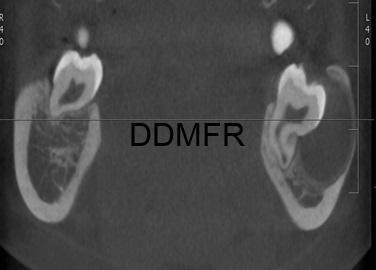

In [12]:
query = "Asymptomatic lesion which usually is located at the periapical region of lower incisors. It is most common in middle-aged women (mostly of black origin). Single or multiple lesions.  Adjacent  teeth:  usually  with  vital  pulp,  without  displacement  or  resorption. The size of the lesion does not exceed 1,5 cm of diameter."
found_texts = qdrant_text.similarity_search(query, k=1)

context = ""
for i in range(len(found_texts)):
    document = found_texts[i] 
    point_id = document.metadata["_id"]
    point = qdrant_client.retrieve(
        collection_name=text_collection_name,
        ids=[point_id],
        with_payload=True,  
        with_vectors=False  
    )

    payload = point[0].payload
    context = payload.get("chunk_text", "")
    print('\nContext---------------------------')
    print(context)

    messages_symptom = [
        {
            "role": "system",
            "content": (
                "You are a helpful assistant who answers the user's question based only on the relevant portions "
                "of the provided context. Do not analyze or mention information that is not directly related "
                "to the user's question. Provide only the most likely disease name with its stage number, and a detailed explanation according to the given context."
                "Do not go beyond the provided context, answer within 77 tokens."
            )
        },
        {
            "role": "user",
            "content": (
                f"The user's question is: {query}\n\n"
                "Below is some background information, only partial information is related. Only use it if it helps directly answer the question:\n\n"
                f"{context}\n\n"
            )
        }
    ]
    

    response_symptom = openai_client.chat.completions.create(
        model="gpt-4",
        messages=messages_symptom,
        max_tokens=300,
    )

    symptom = response_symptom.choices[0].message.content
    print('\nSymptom--------------------------------------')
    print(symptom)

    found_images = qdrant_image.similarity_search(symptom, k=1)

    document = found_images[0] 
    point_id = document.metadata["_id"]
    point = qdrant_client.retrieve(
        collection_name=image_collection_name,
        ids=[point_id],
        with_payload=True,  
        with_vectors=False  
    )

    payload = point[0].payload
    image_path = payload.get('image_path')
    display(Image(filename=image_path))